In [1]:
# packages

# JAX
import jax.numpy as np
from jax import grad, hessian, vmap

# numpy
import numpy as onp
from numpy import random

# plot figures
import matplotlib.pyplot as plt

Solve the PDE $$-\Delta u + \alpha u^m = f$$ 
subject to boundary conditions $$u = g$$
on the unit box in 2D. 

There are two parameters: $\alpha$ and $m$ controlling the nonlinearity of this equation

In [2]:
# dimension of the PDEs
dim = 2

# set parameters
alpha = 1
m = 3

# fix random seeds, for generating reference solution & sampled points
random.seed(10)

# ground truth solution
def u(x1, x2):
    return np.sin(np.pi*x1) * np.sin(np.pi*x2) + 2*np.sin(4*np.pi*x1) * np.sin(4*np.pi*x2)

# right hand side
def f(x1, x2):
    return -grad(grad(u,0),0)(x1, x2)-grad(grad(u,1),1)(x1, x2)+alpha*(u(x1, x2)**m)

# boundary value
def g(x1, x2):
    return u(x1, x2)


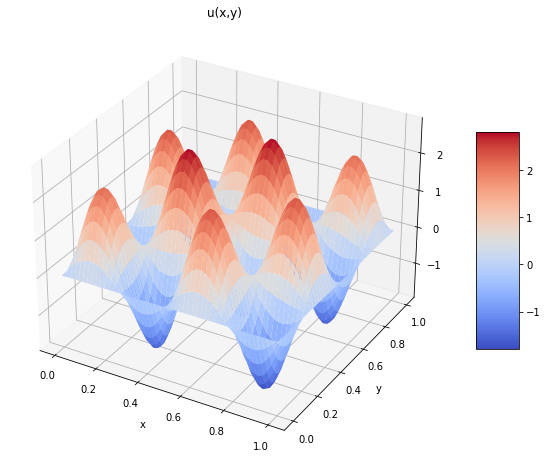

In [3]:
# plot the figure for u and f

def plot_u(num_pts):
    xx = np.linspace(0, 1, num_pts)
    yy = np.linspace(0, 1, num_pts)
    XX, YY = np.meshgrid(xx, yy)

    # vectorized (x,y) coordinates
    XXv = np.array(XX.flatten())
    YYv = np.array(YY.flatten())

    ZZ_u = vmap(u)(XXv, YYv)
    ZZ_u = ZZ_u.reshape(num_pts,num_pts)
    
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')
    u_surf=ax.plot_surface(XX, YY, ZZ_u, cmap=plt.cm.coolwarm)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('u(x,y)')
    
    fig.colorbar(u_surf, shrink= 0.5, aspect = 5)
    plt.show()

def plot_f(num_pts):
    xx = np.linspace(0, 1, num_pts)
    yy = np.linspace(0, 1, num_pts)
    XX, YY = np.meshgrid(xx, yy)

    # vectorized (x,y) coordinates
    XXv = np.array(XX.flatten())
    YYv = np.array(YY.flatten())

    ZZ_f = vmap(f)(XXv, YYv)
    ZZ_f = ZZ_f.reshape(num_pts,num_pts)
    return XX, YY, ZZ_f
    
    
plot_u(50)

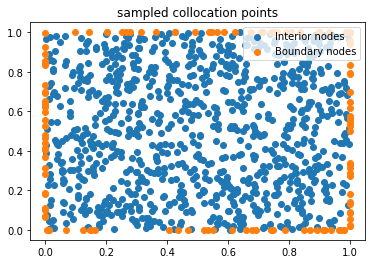

In [4]:
# sampled collocation points

def sample_points(N_domain, N_boundary):
    # interior nodes
    X_domain = random.uniform(0.0, 1.0, (N_domain, 2))
    X_boundary = onp.zeros((N_boundary, 2))

    # generate random boundary points on the faces of the domain 

    # bottom face
    X_boundary[range(int(N_boundary/4)), 0] = random.uniform(0.0, 1.0, int(N_boundary/4))
    # right face
    X_boundary[range(int(N_boundary/4), 2*int(N_boundary/4)), 0] += 1
    X_boundary[range(int(N_boundary/4), 2*int(N_boundary/4)), 1] = \
        random.uniform(0.0, 1.0, int(N_boundary/4))
    # top face
    X_boundary[range(2*int(N_boundary/4), 3*int(N_boundary/4)), 0] = \
        random.uniform(0.0, 1.0, int(N_boundary/4))
    X_boundary[range(2*int(N_boundary/4), 3*int(N_boundary/4)), 1] += 1
    # left face
    X_boundary[range(3*int(N_boundary/4), 4*int(N_boundary/4)), 1] = \
        random.uniform(0.0, 1.0, int(N_boundary/4))
    return X_domain, X_boundary

N_pts = 30
N_domain_tot = N_pts**2
N_boundary_tot = 4*(N_pts+1)
X_domain_tot, X_boundary_tot = sample_points(N_domain_tot, N_boundary_tot)

fig, ax = plt.subplots()
ax.scatter(X_domain_tot[range(N_domain_tot), 0], X_domain_tot[range(N_domain_tot), 1], label='Interior nodes')
ax.scatter(X_boundary_tot[range(N_boundary_tot), 0], X_boundary_tot[range(N_boundary_tot), 1], label='Boundary nodes')
ax.legend(loc="upper right")
plt.title('sampled collocation points')
plt.show()

In [5]:
# Define a real valued kernel kappa(x, y; sigma) \to R
def kappa(x1, x2, y1, y2, sigma):
    # x,y are 2D input row vectors
    # sigma is the variance parameter
    return np.exp(-(1/(2*sigma**2))*( (x1- y1)**2 + (x2 - y2)**2 ))

# define derivatives of the kernel 
def Delta_x_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(kappa, 0), 0)(x1, x2, y1, y2, sigma)
    val += grad(grad(kappa, 1), 1)(x1, x2, y1, y2, sigma)
    return val

def Delta_y_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(kappa, 2), 2)(x1, x2, y1, y2, sigma)
    val += grad(grad(kappa, 3), 3)(x1, x2, y1, y2, sigma)
    return val

def Delta_x_y_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(Delta_y_kappa, 0), 0)(x1, x2, y1, y2, sigma)
    val += grad(grad(Delta_y_kappa, 1), 1)(x1, x2, y1, y2, sigma)
    return val


In [6]:
# vectorized construction of Theta
def assembly_Theta(X_domain, X_boundary, nugget, set_sigma):
    N_domain = X_domain.shape[0]
    N_boundary = X_boundary.shape[0]
    Theta = onp.zeros((2*N_domain + N_boundary, 2*N_domain + N_boundary))

    # auxiliary variables to make things readable
    Xd0=X_domain[:N_domain, 0]
    Xd1=X_domain[:N_domain, 1]

    Xdb0=np.concatenate([Xd0, X_boundary[:N_boundary, 0]])
    Xdb1=np.concatenate([Xd1, X_boundary[:N_boundary, 1]])

    # interior -- interior 
    XXdd0=np.transpose(np.tile(Xd0,(N_domain,1)))
    XXdd1=np.transpose(np.tile(Xd1,(N_domain,1)))

    # interior+boudary -- interior+bpundary
    XXdbdb0=np.transpose(np.tile(Xdb0,(N_domain+N_boundary,1)))
    XXdbdb1=np.transpose(np.tile(Xdb1,(N_domain+N_boundary,1)))

    # interior v.s. interior+boundary
    XXddb0=np.transpose(np.tile(Xd0,(N_domain+N_boundary,1)))
    XXddb1=np.transpose(np.tile(Xd1,(N_domain+N_boundary,1)))
    XXddb0_2=np.tile(Xdb0,(N_domain,1))
    XXddb1_2=np.tile(Xdb1,(N_domain,1))

    # Construct kernel matrix
    # interior v.s. interior (Laplace)
    val = vmap(lambda x1, x2, y1, y2: Delta_x_y_kappa(x1, x2, y1, y2, set_sigma))(XXdd0.flatten(),XXdd1.flatten(),onp.transpose(XXdd0).flatten(),onp.transpose(XXdd1).flatten())
    Theta[0:N_domain, 0:N_domain] =  onp.reshape(val, (N_domain, N_domain))
    
    # interior+boundary v.s. interior+boundary
    val = vmap(lambda x1, x2, y1, y2: kappa(x1, x2, y1, y2, set_sigma))(XXdbdb0.flatten(),XXdbdb1.flatten(),onp.transpose(XXdbdb0).flatten(),onp.transpose(XXdbdb1).flatten())
    Theta[N_domain:, N_domain:] =  onp.reshape(val, (N_domain+N_boundary, N_domain+N_boundary))

    # interior v.s. interior+boundary
    val = vmap(lambda x1, x2, y1, y2: Delta_x_kappa(x1, x2, y1, y2, set_sigma))(XXddb0.flatten(),XXddb1.flatten(),XXddb0_2.flatten(),XXddb1_2.flatten())
    Theta[:N_domain, N_domain:] = onp.reshape(val, (N_domain, N_domain+N_boundary))
    Theta[N_domain:, :N_domain] = onp.transpose(onp.reshape(val, (N_domain, N_domain+N_boundary)))
    
    # calculate trace
    trace1 = np.trace(Theta[:N_domain, :N_domain])
    trace2 = np.trace(Theta[N_domain:, N_domain:])
    ratio = trace1/trace2
    
    temp=np.concatenate((ratio*np.ones((1,N_domain)),np.ones((1,N_domain+N_boundary))), axis=1)
    Theta = Theta + set_nugget*np.diag(temp[0])
    L = np.linalg.cholesky(Theta)
    
    return L, ratio

# test
set_sigma = 0.2
set_nugget = 1e-5
L, ratio = assembly_Theta(X_domain_tot, X_boundary_tot, set_nugget, set_sigma)
print('trace ratio =', ratio)
print('observation: the trace ratio is large, and our adaptive nugget term is effective')

trace ratio = 4394.5312
observation: the trace ratio is large, and our adaptive nugget term is effective


In the above, we added nugget terms to regularize the Gram matrix
\begin{equation*}
\Theta_{\lambda} = \Theta +
\text{nugget}\times\begin{bmatrix}
\lambda I & 0 \\
0 & I 
\end{bmatrix}
\end{equation*}
where $\lambda$ is selected to be the trace ratio of the orginal Gram matrix

Then, we solve the following optimization problem:
\begin{equation*}
\begin{aligned}
\min&\quad   [v,w,u_b]\Theta_{\lambda}^{-1} [v,w,u_b]^T\\
  \text{s.t.}&\quad -v+\alpha w^m=f, \text{ and } u_b = \text{boundary data}
\end{aligned}
\end{equation*}

Here, $v,w$ represent the interior nodal values of $\Delta u(x_i), u(x_i)$, respectively.

iter = 0 J = 15105257.0
iter =  1 Gauss-Newton step size = 1  J =  10873.847
iter =  2 Gauss-Newton step size = 1  J =  5524.5596
iter =  3 Gauss-Newton step size = 1  J =  5524.515
iter =  4 Gauss-Newton step size = 1  J =  5524.5107
iter =  5 Gauss-Newton step size = 1  J =  5524.5103


Text(0.5, 1.0, 'Loss function history')

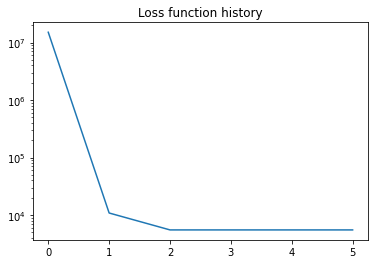

In [7]:
# loss function
def J(z,rhs_f,bdy_g,L):
    zz = np.append(alpha*(z**m) - rhs_f, z) 
    ww = np.append(zz, bdy_g)
    ss = np.linalg.solve(L, ww)
    return np.dot(ss, ss)

grad_J=grad(J)

# linearized loss function: used for GN method
def GN_J(z,rhs_f,bdy_g,L,z_old):
    zz = np.append(alpha*m*(z_old**(m-1))*(z-z_old), z) 
    ww = np.append(zz, bdy_g)
    ss = np.linalg.solve(L, ww)
    return np.dot(ss, ss)

Hessian_GN=hessian(GN_J)

def pde_solver(X_domain, X_boundary, nugget, max_iter, step_size, initial_sol, set_sigma):
    rhs_f = vmap(f)(X_domain[:,0], X_domain[:,1])
    bdy_g = vmap(u)(X_boundary[:,0], X_boundary[:,1])
    L, ratio = assembly_Theta(X_domain, X_boundary, nugget, set_sigma)

    sol = initial_sol
    J_hist = [] # history of loss function values
    J_now = J(sol,rhs_f,bdy_g,L)
    J_hist.append(J_now)
    
    print('iter = 0', 'J =', J_now) # print out history
    
    for iter_step in range(1, max_iter+1):
        temp = np.linalg.solve(Hessian_GN(sol,rhs_f,bdy_g,L,sol), grad_J(sol,rhs_f,bdy_g,L))
        sol = sol - step_size*temp  
        
        J_now = J(sol,rhs_f,bdy_g,L)
        J_hist.append(J_now)
        # print out history
        print('iter = ', iter_step, 'Gauss-Newton step size =', step_size, ' J = ', J_now)               
    return sol, J_hist, L

initial_sol = random.normal(0.0, 1.0, (N_domain_tot)) # random initial guess
max_iter = 5
step_size = 1
set_sigma = 0.2
set_nugget = 1e-4
sol, J_hist, L = pde_solver(X_domain_tot, X_boundary_tot, set_nugget, max_iter, step_size, initial_sol, set_sigma)

plt.plot(np.arange(max_iter+1),J_hist)
plt.yscale("log")
plt.title('Loss function history')

In [8]:
# err at collocation points

sol_truth = vmap(u)(X_domain_tot[:,0], X_domain_tot[:,1])
err_pts = abs(sol_truth-sol)

max_err_pts = np.max(err_pts)

L2_err_pts = np.sqrt(np.sum(err_pts**2) / (N_domain_tot))

print('At collocation points, L2 err= ', L2_err_pts, ' max err=', max_err_pts)

At collocation points, L2 err=  0.0033211953  max err= 0.02044953


In [9]:
# use kernel interpolation to extend the solution at test points

def construct_inpTheta(X_test, X_domain, X_boundary):
    N_test = X_test.shape[0]
    N_domain = X_domain.shape[0]
    N_boundary = X_boundary.shape[0]
    inpTheta = onp.zeros((N_test, 2*N_domain + N_boundary))

    # auxiliary variables to make things readable
    
    # X_test coordinates
    Xt0=X_test[:,0]
    Xt1=X_test[:,1]
    
    # interior points coordinates
    Xd0=X_domain[:N_domain, 0]
    Xd1=X_domain[:N_domain, 1]
    
    # interior + boundary points coordinates
    Xdb0=np.concatenate([Xd0, X_boundary[:N_boundary, 0]])
    Xdb1=np.concatenate([Xd1, X_boundary[:N_boundary, 1]])
    
    # test v.s. interior
    XXtd0=np.transpose(np.tile(Xt0,(N_domain,1)))
    XXtd1=np.transpose(np.tile(Xt1,(N_domain,1)))
    XXtd0_2=np.tile(Xd0,(N_test,1))
    XXtd1_2=np.tile(Xd1,(N_test,1))
    
    # test v.s. interior + boundary
    XXtdb0=np.transpose(np.tile(Xt0,(N_domain+N_boundary,1)))
    XXtdb1=np.transpose(np.tile(Xt1,(N_domain+N_boundary,1)))
    XXtdb0_2=np.tile(Xdb0,(N_test,1))
    XXtdb1_2=np.tile(Xdb1,(N_test,1))
    
    # constructing Theta matrix
    val = vmap(lambda x1,x2,y1,y2: Delta_y_kappa(x1, x2, y1, y2, set_sigma))(XXtd0.flatten(),XXtd1.flatten(),XXtd0_2.flatten(),XXtd1_2.flatten())
    inpTheta[:,:N_domain] = onp.reshape(val, (N_test, N_domain))
    
    val = vmap(lambda x1,x2,y1,y2: kappa(x1, x2, y1, y2, set_sigma))(XXtdb0.flatten(),XXtdb1.flatten(),XXtdb0_2.flatten(),XXtdb1_2.flatten())
    inpTheta[:, N_domain:] = onp.reshape(val, (N_test, N_domain+N_boundary))
    return inpTheta


def extend_solution(X_test, X_domain, X_boundary, L, v):
        
    inp_Theta = construct_inpTheta(X_test, X_domain, X_boundary)
    
    aux = np.linalg.solve(np.transpose(L),np.linalg.solve(L,v))
    
    extended_u = np.matmul(inp_Theta,aux)
    return extended_u

def sol_and_err_extended(num_pts, X_domain, X_boundary, L, sol):
    # num_pts is the number of test points in each dimension
    xx= np.linspace(0, 1, num_pts)
    yy = np.linspace(0, 1, num_pts)
    XX, YY = np.meshgrid(xx, yy)

    # vectorized (x,y) coordinates
    XXv = np.array(XX.flatten())
    YYv = np.array(YY.flatten())
    XXv = np.expand_dims(XXv, axis=1) 
    YYv = np.expand_dims(YYv, axis=1) 

    X_test = np.concatenate((XXv,YYv), axis=1)

    rhs_f = vmap(f)(X_domain[:,0], X_domain[:,1])
    bdy_g = vmap(u)(X_boundary[:,0], X_boundary[:,1])
    v = np.append(alpha*(sol**m) - rhs_f, sol) 
    v = np.append(v, bdy_g)

    # extend the solution to test points
    extended_u = extend_solution(X_test, X_domain_tot, X_boundary_tot, L, v)
    extended_u = extended_u.reshape(num_pts,num_pts)
    
    # u_truth
    u_truth = vmap(u)(XXv, YYv)
    u_truth = u_truth.reshape(num_pts,num_pts)
    
    # err
    mtx_err = abs(extended_u-u_truth)
    
    # L2err
    L2err = np.linalg.norm(extended_u-u_truth,'fro')/(num_pts)
    
    # Maxerr
    Maxerr = np.max(abs(extended_u-u_truth))
    
    return XX, YY, extended_u, u_truth, mtx_err, L2err, Maxerr

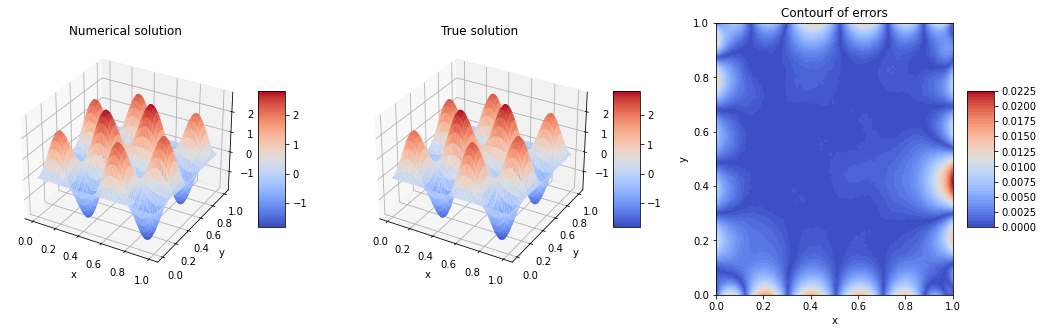

sigma = 0.2 , nugget = 0.0001 , # pts:  1024 , L2 error:  0.0034161569 , max err:  0.022102335


In [10]:
# plot the extended solution in the whole domain, and calculate the errors
num_pts=100
XX, YY, extended_u, u_truth, mtx_err, L2err, Maxerr = sol_and_err_extended(num_pts, X_domain_tot, X_boundary_tot, L, sol)

fig = plt.figure(figsize=(18,5))

# plot the numerical solution
ax = fig.add_subplot(131, projection='3d')
u_sol_surf=ax.plot_surface(XX, YY, extended_u, cmap=plt.cm.coolwarm)
plt.xlabel('x'); plt.ylabel('y'); plt.title('Numerical solution')
fig.colorbar(u_sol_surf, shrink= 0.5, aspect = 5)
    
# plot the true solution
ax = fig.add_subplot(132, projection='3d')
u_truth_surf=ax.plot_surface(XX, YY, u_truth, cmap=plt.cm.coolwarm)
plt.xlabel('x'); plt.ylabel('y'); plt.title('True solution')
fig.colorbar(u_truth_surf, shrink= 0.5, aspect = 5)

# contourf
ax = fig.add_subplot(133)
u_contourf=ax.contourf(XX, YY, mtx_err, 50, cmap=plt.cm.coolwarm)
plt.xlabel('x'); plt.ylabel('y'); plt.title('Contourf of errors')
fig.colorbar(u_contourf, shrink= 0.5, aspect = 5)

plt.show()

# calculate the L2 error
print('sigma =', set_sigma, ', nugget =', set_nugget, ', # pts: ', N_domain_tot+N_boundary_tot, ', L2 error: ', L2err, ', max err: ', Maxerr)

In [11]:
# prepare data for plot

# fig for f, u, sol_u
# fig for collocation-pts, iteration history, err_contour

num_pts_for_plot = 100
XX, YY, ZZ_f = plot_f(num_pts_for_plot)

N_pts = 30
N_domain_tot = N_pts**2
N_boundary_tot = 4*(N_pts+1)
X_domain_tot, X_boundary_tot = sample_points(N_domain_tot, N_boundary_tot)

initial_sol = random.normal(0.0, 1.0, (N_domain_tot)) # random initial guess
max_iter = 5
step_size = 1
set_sigma = 0.15878296
set_nugget = 1e-5
sol, J_hist, L = pde_solver(X_domain_tot, X_boundary_tot, set_nugget, max_iter, step_size, initial_sol, set_sigma)

XX, YY, extended_u, u_truth, mtx_err, L2err, Maxerr = sol_and_err_extended(num_pts_for_plot, X_domain_tot, X_boundary_tot, L, sol)
print('sigma =', set_sigma, ', nugget =', set_nugget, ', # pts: ', N_domain_tot+N_boundary_tot, ', L2 error: ', L2err, ', max err: ', Maxerr)


iter = 0 J = 173847860.0
iter =  1 Gauss-Newton step size = 1  J =  32299.137
iter =  2 Gauss-Newton step size = 1  J =  781.9557
iter =  3 Gauss-Newton step size = 1  J =  781.94366
iter =  4 Gauss-Newton step size = 1  J =  781.94366
iter =  5 Gauss-Newton step size = 1  J =  781.9409
sigma = 0.15878296 , nugget = 1e-05 , # pts:  1024 , L2 error:  0.00027502954 , max err:  0.0069094896


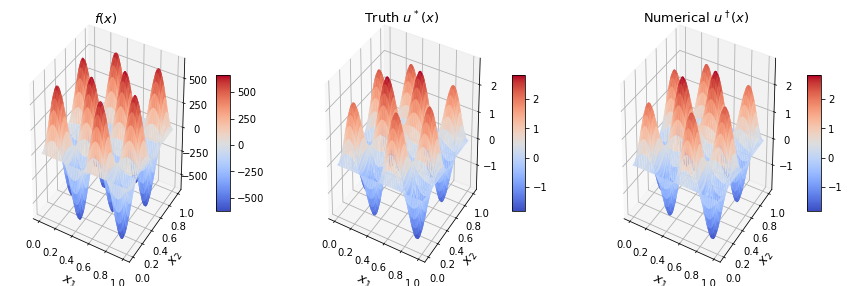

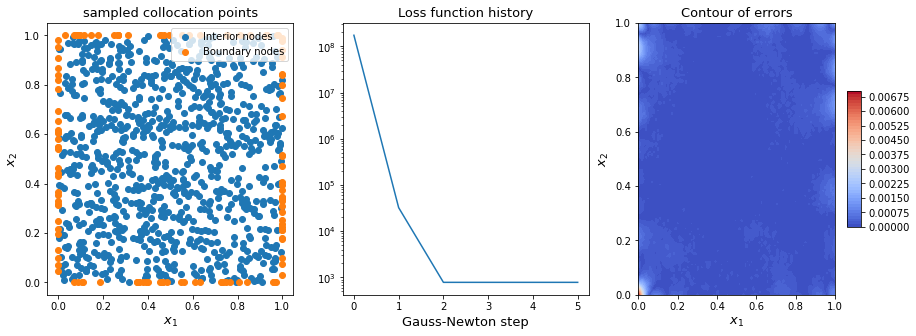

<Figure size 432x288 with 0 Axes>

In [12]:
# plot figures
here_fontsize=13

# --------------first set of figure---------------------
fig = plt.figure(figsize=(15,5))

# plot the numerical solution
ax = fig.add_subplot(131, projection='3d')
f_surf=ax.plot_surface(XX, YY, ZZ_f, cmap=plt.cm.coolwarm)
plt.xlabel('$x_1$', fontsize=here_fontsize)
plt.ylabel('$x_2$', fontsize=here_fontsize) 
plt.title('$f(x)$', fontsize=here_fontsize)
fig.colorbar(f_surf, shrink= 0.5, aspect = 10)

# plot the true solution
ax = fig.add_subplot(132, projection='3d')
u_truth_surf=ax.plot_surface(XX, YY, u_truth, cmap=plt.cm.coolwarm)
plt.xlabel('$x_1$', fontsize=here_fontsize)
plt.ylabel('$x_2$', fontsize=here_fontsize) 
plt.title('Truth $u^*(x)$', fontsize=here_fontsize)
fig.colorbar(u_truth_surf, shrink= 0.5, aspect = 10)

# numerical solution
ax = fig.add_subplot(133, projection='3d')
u_extend_surf=ax.plot_surface(XX, YY, extended_u, cmap=plt.cm.coolwarm)
plt.xlabel('$x_1$', fontsize=here_fontsize)
plt.ylabel('$x_2$', fontsize=here_fontsize)
plt.title('Numerical $u^\dagger(x)$', fontsize=here_fontsize)
fig.colorbar(u_extend_surf, shrink= 0.5, aspect = 10)

plt.show()
fig.tight_layout()
# fig.savefig('Elliptic_pts1024_sol_plt.pdf', bbox_inches='tight',dpi=100,pad_inches=0.15)

# --------------second set of figure---------------------
fig = plt.figure(figsize=(15,5))

# plot the contour error
ax = fig.add_subplot(133)
u_contourf=ax.contourf(YY, XX, abs(extended_u-u_truth), 50, cmap=plt.cm.coolwarm)
plt.xlabel('$x_1$', fontsize=here_fontsize)
plt.ylabel('$x_2$', fontsize=here_fontsize)
plt.title('Contour of errors', fontsize=here_fontsize)
fig.colorbar(u_contourf, shrink= 0.5, aspect = 10)

# plot the collocation pts
ax = fig.add_subplot(131)
ax.scatter(X_domain_tot[range(N_domain_tot), 0], X_domain_tot[range(N_domain_tot), 1], label='Interior nodes')
ax.scatter(X_boundary_tot[range(N_boundary_tot), 0], X_boundary_tot[range(N_boundary_tot), 1], label='Boundary nodes')
ax.legend(loc="upper right")
plt.title('sampled collocation points', fontsize=here_fontsize)
plt.xlabel('$x_1$', fontsize=here_fontsize)
plt.ylabel('$x_2$', fontsize=here_fontsize) 

# plot the iteration history
ax = fig.add_subplot(132)
plt.plot(np.arange(max_iter+1),J_hist)
plt.yscale("log")
plt.title('Loss function history', fontsize=here_fontsize)
plt.xlabel('Gauss-Newton step', fontsize=here_fontsize)

plt.show()
fig.tight_layout()
plt.subplots_adjust(top=1,bottom=0,left=0,right=0.1,hspace=0,wspace=0) 
# fig.savefig('Elliptic_pts1024_pts_iteration_contour_err.pdf', bbox_inches='tight',dpi=100,pad_inches=0.15)



In [14]:
# np.savez('data_nonlinear_elliptic_demon.npz', XX=XX, YY=YY, extended_u=extended_u, u_truth=u_truth, X_domain_tot = X_domain_tot, X_boundary_tot=X_boundary_tot, max_iter=max_iter, J_hist=J_hist)